In this activity, we'll use the Kaggle House Prices: Advanced Regression Techniques database (available at https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data , that we did EDA, Exploratory Data Analysis and Visualization. This dataset is aimed toward solving a regression problem (that is, the target variable takes on a range of continuous values). In this activity, we will use decision trees, K-nearest neighbors, Random Forest, and gradient boosting algorithms to train individual regressors on the data. Then, we will build a stacked linear regression model that uses all these algorithms and compare the performance of each. We will use the mean absolute error (MAE) as the evaluation metric for this activity.

The steps to be performed are as follows:

## 1. Import the relevant libraries.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

## Read and preprocess data

In [86]:
train_data = pd.read_csv("house_prices.csv")
test = pd.read_csv("house_prices.csv")

In [88]:
Sale_Price=train_data.iloc[:,80]
Sale_Price.shape

(1460,)

In [89]:
train_data.shape

(1460, 81)

In [90]:
train=train_data.drop(["SalePrice"],axis=1)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [91]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Preprocess the dataset to remove null values and one-hot encode categorical variables to prepare the data for modeling.

In [92]:
data= pd.concat([train,test], keys=['x', 'y'])#here X is training data and Y testing data
data=data.drop(["Id"],axis=1)

In [133]:
total_null = data.isnull().sum().sort_values(ascending=False) #First sum and order all null values for each variable
percentage = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False) #Get the percentage
missing_data = pd.concat([total_null, percentage], axis=1, keys=['Total', 'Percentage'])
missing_data.head(20)

,Total,Percentage
PoolQC,2906,0.995205
MiscFeature,2812,0.963014
Alley,2738,0.937671
Fence,2358,0.807534
SalePrice,1460,0.500000
FireplaceQu,1380,0.472603
LotFrontage,518,0.177397
GarageCond,162,0.055479
GarageYrBlt,162,0.055479
GarageFinish,162,0.055479


In [134]:
df=data.drop(["RoofMatl","Heating","Condition2","BsmtCond","SaleType",
                "CentralAir","Functional","Electrical","LandSlope","ExterCond","Condition1",
               "GarageArea","BsmtUnfSF","3SsnPorch","MiscVal"],axis=1) 

In [135]:
df=df.drop(["BldgType","Exterior1st","Exterior2nd","Foundation","BsmtFinType2","YrSold","SaleCondition","RoofStyle"],axis=1)

In [136]:
n_features = df.select_dtypes(exclude = ["object"]).columns

In [137]:
def mod_outlier(df):
        df1 = df.copy()
        df = df._get_numeric_data()


        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)


        for col in df.columns:
            for i in range(0,len(df[col])):
                if df[col][i] < lower_bound[col]:            
                    df[col][i] = lower_bound[col]

                if df[col][i] > upper_bound[col]:            
                    df[col][i] = upper_bound[col]    


        for col in df.columns:
            df1[col] = df[col]

        return(df1)

In [138]:
df = mod_outlier(df)

<ipython-input-137-0bd91ed0b379>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = upper_bound[col]
<ipython-input-137-0bd91ed0b379>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = lower_bound[col]


## Divide the dataset into train and validation DataFrames.

In [146]:
x=Train_data.drop(["SalePrice"],axis=True)
y=Train_data["SalePrice"]

In [147]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=40)

## Initialize dictionaries in which to store the train and validation MAE values.

In [151]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

In [153]:
X = train_data.drop(columns=['y'])
y = train_data['y'].values

y_pred = reg.predict(X)

KeyError: "['y'] not found in axis"

## Train a decision tree model with the following hyperparameters and save the scores:

In [149]:
dtr=DecisionTreeRegressor(random_state=11,min_samples_split=5,min_impurity_decrease=0.002,min_weight_fraction_leaf=0.001)
dtr.fit(x_train,y_train)

print(dtr.score(x_test,y_test))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## Train a k-nearest neighbors model with the following hyperparameters and save the scores:

In [3]:
knn_params = {
    'n_neighbors': 5
}

#insert code here for modelling



## Train a Random Forest model with the following hyperparameters and save the scores:

In [4]:
rf_params = {
    'n_estimators': 50,
    'criterion': 'mae',
    'max_features': 'sqrt',
    'min_samples_leaf': 10,
    'random_state': 11,
    'n_jobs': -1
}
#insert code here for modelling



## Train a gradient boosting model with the following hyperparameters and save the scores:

In [5]:
gbr_params = {
    'n_estimators': 50,
    'criterion': 'mae',
    'max_features': 'sqrt',
    'min_samples_leaf': 10,
    'random_state': 11
}
#insert code here for modelling



## Prepare the training and validation datasets, with the four meta estimators having the same hyperparameters that were used in the previous steps.

## Train a linear regression model as the stacked model.

## Visualize the train and validation errors for each individual model and the stacked model.

Reference Result/Output:

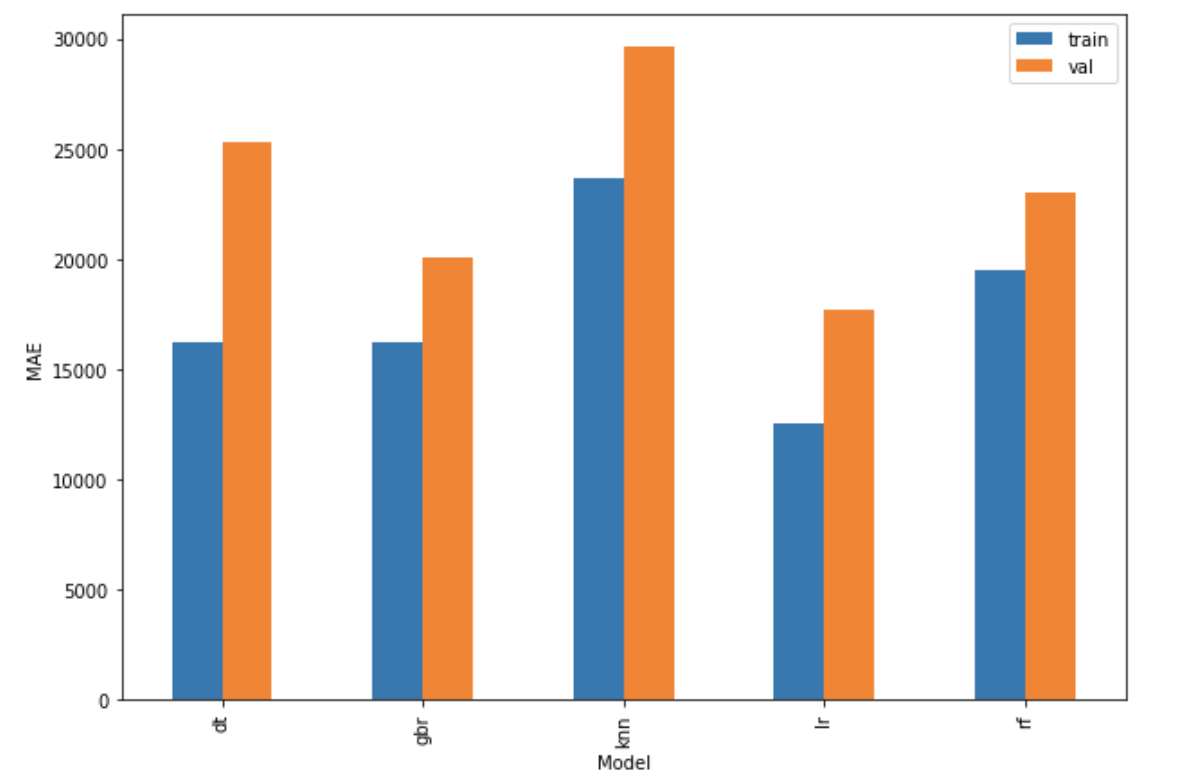